In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings
import locale
from matplotlib.dates import (YEARLY, DateFormatter,
                              rrulewrapper, RRuleLocator, drange)

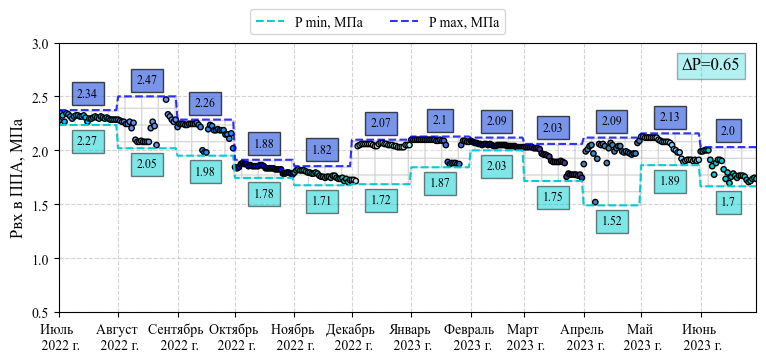

In [232]:
Month_1 = 'Факт-07.2022 - 06.2023\Суточные сводки\Июль'
Month_2 = 'Факт-07.2022 - 06.2023\Суточные сводки\Август'
Month_3 = 'Факт-07.2022 - 06.2023\Суточные сводки\Сентябрь'
Month_4 = 'Факт-07.2022 - 06.2023\Суточные сводки\Октябрь'
Month_5 = 'Факт-07.2022 - 06.2023\Суточные сводки\Ноябрь'
Month_6 = 'Факт-07.2022 - 06.2023\Суточные сводки\Декабрь'
Month_7 = 'Факт-07.2022 - 06.2023\Суточные сводки\Январь'
Month_8 = 'Факт-07.2022 - 06.2023\Суточные сводки\Февраль'
Month_9 = 'Факт-07.2022 - 06.2023\Суточные сводки\Март'
Month_10 = 'Факт-07.2022 - 06.2023\Суточные сводки\Апрель'
Month_11 = 'Факт-07.2022 - 06.2023\Суточные сводки\Май'
Month_12 = 'Факт-07.2022 - 06.2023\Суточные сводки\Июнь'
folders = [Month_1, Month_2, Month_3, Month_4, Month_5, Month_6, Month_7, Month_8, Month_9, Month_10, Month_11, Month_12]
res_year = pd.DataFrame([], columns=['Дата','Р_ППА'])
for files in folders:
    files_3 = files + '\\' + '_06_Технологический_режим_работы_ППА_КСГ_ЮРНГМ.xlsx'
    Excel_3 = pd.read_excel(files_3)
    Excel_3.replace({0:np.nan}, inplace=True)
    Excel_3.replace({'РЕМ':np.nan}, inplace=True)
    Excel_3.replace({'РЕЗ':np.nan}, inplace=True)
    bedin = Excel_3[Excel_3.iloc[:,0] == 'Дата'].index[0]
    end = Excel_3[Excel_3.iloc[:,0] == 'Итого'].index[0]
    df_new_3 = Excel_3.iloc[bedin+4:end, :]
    df_new_3['Unnamed: 0'] = pd.to_datetime(df_new_3.iloc[:,0])
    df_new_3['Unnamed: 0'] = df_new_3['Unnamed: 0'].dt.strftime('%d.%m.%Y')
    date = df_new_3.iloc[:,0]    
    df_itog_3 = Excel_3.iloc[end, :]
    p_in_ppa = df_new_3.iloc[:,1] * 0.0980665 + 0.0980665
    form_year = np.vstack([date.values,p_in_ppa.values]).T
    form_year = pd.DataFrame(form_year, columns=['Дата','Р_ППА'])
    res_year = pd.concat([res_year,form_year],ignore_index=True)

mpl.rc('font',family='Times New Roman') #везде TNR
locale.setlocale(locale.LC_ALL, 'ru_RU.UTF-8') #русский язык
formatter = DateFormatter('%B \n %Y г.') #формат даты
res_year['Дата'] = pd.to_datetime(res_year['Дата'], dayfirst=True)
date_min = res_year['Дата'].dt.date.min()
date_max = res_year['Дата'].dt.date.max()
def set_color(date):  #задаем цвета для каждого месяца свой
    color_dict = {
        1: 'royalblue',
        2: 'navy',
        3: 'darkslateblue',
        4: 'steelblue',
        5: 'lightskyblue',
        6: 'darkturquoise',
        7: 'deepskyblue',
        8: 'cornflowerblue',
        9: 'dodgerblue',
        10: 'blue',
        11: 'lightseagreen',
        12: 'paleturquoise'
    }
    month = date.month
    return color_dict[month]
res_year['color'] = res_year['Дата'].apply(set_color)
#Pвх в ППА
res_year['month'] = res_year['Дата'].dt.month
res_year['Р_ППА'] = res_year['Р_ППА'][res_year['Р_ППА'] < 2.5]
res_year['P_min_ppa'] = res_year.groupby('month', as_index=False)['Р_ППА'].transform(min) #ищем максимумы и минимумы по месяцам
res_year['P_max_ppa'] = res_year.groupby('month', as_index=False)['Р_ППА'].transform(max)
df_mark = res_year.groupby('month').agg({'Дата': 'mean','P_min_ppa':'min', 'P_max_ppa':'max'}) #местоположение подписей на графике
fig_1, ax = plt.subplots(figsize=(9, 3.5)) #создаем гарфик и его размеры
plt.fill_between(res_year['Дата'], res_year['P_min_ppa']-0.03, res_year['P_max_ppa']+0.02, step="mid", alpha=0.3, hatch='+', color = 'white', edgecolor='grey') #заливка в выбранной области
plt.scatter(res_year['Дата'], res_year['Р_ППА'], c=res_year['color'],edgecolors='black', s=15) #наносим точки
ax.plot(res_year['Дата'], res_year['P_min_ppa']-0.03, color='darkturquoise', linestyle='--', label='P min, МПа') #линии мин и макс
ax.plot(res_year['Дата'], res_year['P_max_ppa']+0.03, color='b', alpha=0.8, linestyle='--', label='P max, МПа') 
bbox_min = dict(facecolor='darkturquoise',alpha=0.5) #заливка подписей на графике
bbox_max = dict(facecolor='royalblue',alpha=0.7)
df_mark.apply(lambda d: ax.text(d['Дата'],d['P_min_ppa']-0.18, round(d['P_min_ppa'],2), bbox=bbox_min, va='center', ha = 'center', fontsize=8.5), axis=1) #подписи на графике:местоположение, значения, формат   
df_mark.apply(lambda d: ax.text(d['Дата'],d['P_max_ppa']+0.18, round(d['P_max_ppa'],2), bbox=bbox_max, va='center', ha = 'center', fontsize=8.5), axis=1)
dp = (res_year['P_max_ppa'][0] - res_year['P_min_ppa'][364]).__round__(2) 
text = 'ΔP='
plt.text(res_year.Дата.values[325],2.75, f'{text}{dp}', fontsize=12, bbox={'boxstyle':'square', 'facecolor': 'darkturquoise', 'alpha':0.3}) 
ax.xaxis.set_major_formatter(formatter) #формат даты
ax.set_xlim([date_min,date_max]) #пределы по х
ax.set_ylim(0.5,3)#пределы по у
ax.set_ylabel('Рвх в ППА, МПа', fontsize=12) #название оси у
ax.set_axisbelow(True)
ax.grid(color='lightgray', linestyle='dashed') #сетка на графике
plt.legend(fontsize = 10,bbox_to_anchor=(0.65, 1.15), ncol=2)
plt.savefig('P_вх в ппа за пр.г.jpg',bbox_inches="tight", dpi=200)
plt.show()


In [235]:
#Пути к папкам с необходимыми Excel файлами, указываются от места где лежит скрипт !!!Менять тут
Month_1 = 'Факт-07.2023-06.2024\Суточные сводки\Июль'
Month_2 = 'Факт-07.2023-06.2024\Суточные сводки\Август'
Month_3 = 'Факт-07.2023-06.2024\Суточные сводки\Сентябрь'
Month_4 = 'Факт-07.2023-06.2024\Суточные сводки\Октябрь'
Month_5 = 'Факт-07.2023-06.2024\Суточные сводки\Ноябрь'
Month_6 = 'Факт-07.2023-06.2024\Суточные сводки\Декабрь'
Month_7 = 'Факт-07.2023-06.2024\Суточные сводки\Январь'
Month_8 = 'Факт-07.2023-06.2024\Суточные сводки\Февраль'
Month_9 = 'Факт-07.2023-06.2024\Суточные сводки\Март'
Month_10 = 'Факт-07.2023-06.2024\Суточные сводки\Апрель'
Month_11 = 'Факт-07.2023-06.2024\Суточные сводки\Май'
Month_12 = 'Факт-07.2023-06.2024\Суточные сводки\Июнь'
#Создаем фолдер, где будут все папки, после делаем обращение к какой папке из фолдера
folders = [Month_1, Month_2, Month_3, Month_4, Month_5, Month_6, Month_7, Month_8, Month_9, Month_10, Month_11, Month_12]

In [236]:
warnings.filterwarnings("ignore")
res_year = pd.DataFrame([], columns=['Дата','Р_вх', 'Р_вых','е_1_ст','е_2_ст','Р_ППА','Q','TTP'])
res_month = pd.DataFrame([], columns=['Дата','Q', 'Кол-во агр_1','N_ob_1','Р_вх_1', 'T_вх_1', 'е_1_ст','Р_вых_1','T_вых_1', 'P_вых_аво_1','Т_вых_аво_1','Кол-во агр_2', 'N_ob_2','Р_вх_2', 'T_вх_2', 'е_2_ст','Р_вых_2','T_вых_2', 'P_вых_аво_2','Т_вых_аво_2', 'T_теплооб'])
res_month_sep = pd.DataFrame([], columns=['Дата', 'Р_вх_1', 'Р_вых_1', 'T_вх_1', 'T_вых_1', 'Q', 'Кол-во агр', 'Объем отс. ВМС', 'T_вх_тепл', 'T_вых_тепл','Q_1сеп'])
res_month_abs = pd.DataFrame([], columns=['Дата', 'Q','Р_вх_1', 'T_вх_1', 'Кол-во агр', 'Q_1абс', 'Подача ТЭГ', 'Потери ТЭГ', 'TТР'])
res_month_potery_1 = pd.DataFrame([], columns=['Дата', 'Р_вх_ппа','Р_вых_ппа', 'dР_ппа','Р_вых_sep','dР_sep', 'Р_вых_tepl', 'dР_tepl', 'Р_вх_1', 'dР_tepl-1st','Р_вых_1', 'Р_нагнет', 'dР_1st_нагн', 'Р_аво', 'dР_нагн_аво1', 'Р_вх_2', 'dР_аво1_2ст','Р_вых_2','dР_все_потери'])
res_month_potery_2 = pd.DataFrame([], columns=['Дата', 'Р_вых_2', 'P_вых_аво_2', 'dР_avo_tepl', 'Р_вх_tepl','Р_вых_tepl','dР_tepl', 'dР_все_потери'])
res_month_potery_3 = pd.DataFrame([], columns=['Дата','Р_вых_tepl', 'Р_вых_abs', 'dР_tepl_abs', 'Р_вых_uzg', 'dР_abs_uzg', 'dР_all_tepl_uzg', 'dР_all'])
for files in folders:
    files_1 = files + '\\' + '_07_Технологический режим работы ДКС ЮРНГМ.xlsx'
    Excel_1 = pd.read_excel(files_1)
    Excel_1.replace({0:np.nan}, inplace=True)
    Excel_1.replace({'РЕМ':np.nan}, inplace=True)
    Excel_1.replace({'РЕЗ':np.nan}, inplace=True)
    Excel_1.replace({' ':np.nan}, inplace=True)
    bedin = Excel_1[Excel_1.iloc[:,0] == 'Дата'].index[0]
    end = Excel_1[Excel_1.iloc[:,0] == 'Итого'].index[0]
    df_new = Excel_1.iloc[bedin+3:end, :]
    df_itog = Excel_1.iloc[end, :]
    df_new['Unnamed: 0'] = pd.to_datetime(df_new.iloc[:,0])
    df_new['Unnamed: 0'] = df_new['Unnamed: 0'].dt.strftime('%d.%m.%Y')
    date = df_new.iloc[:,0]
    #год
    p_in_1st = (df_new.iloc[:,[5,12,19,26,33,40,47]] * 0.0980665 + 0.0980665).mean(axis=1)
    st_sg_1st = df_new.iloc[:,52] 
    p_out_2st = (df_new.iloc[:,[64,71,78,85,92,99,106]] * 0.0980665 + 0.0980665).mean(axis=1)
    st_sg_2st = df_new.iloc[:,109] 
    #месяц
    date_m = pd.Series(df_new.iloc[0,0])
    p_in_1st_m = np.nanmean((df_itog.iloc[[5,12,19,26,33,40,47]] * 0.0980665 + 0.0980665).values)
    t_in_1st_m = np.nanmean(df_itog.iloc[[6,13,20,27,34,41,48]].values)
    p_out_1st_m = np.nanmean((df_itog.iloc[[7,14,21,28,35,42,49]] * 0.0980665 + 0.0980665).values)
    t_out_1st_m = np.nanmean(df_itog.iloc[[8,15,22,29,36,43,50]].values)
    st_sg_1st_m = df_itog.iloc[52] 
    obor_1st = np.nanmean(df_itog.iloc[[3,10,17,24,31,38,45]].values)
    p_avo_1st = (df_new.iloc[:,55].loc[df_new.iloc[:,55] > 10] * 0.0980665 + 0.0980665).mean()
    t_avo_1st = df_itog.iloc[56]
    W_a_1_st = np.mean([elem for elem in df_new.iloc[:,[5,12,19,26,33,40,47]].count(axis=1) if elem !=0]).__round__(0) 
    p_in_2st_m = np.nanmean((df_itog.iloc[[62,69,76,83,90,97,104]] * 0.0980665 + 0.0980665).values)
    t_in_2st_m = np.nanmean(df_itog.iloc[[63,70,77,84,91,98,105]].values)
    p_out_2st_m = np.nanmean((df_itog.iloc[[64,71,78,85,92,99,106]] * 0.0980665 + 0.0980665).values)
    t_out_2st_m = np.nanmean(df_itog.iloc[[65,72,79,86,93,100,107]].values)
    st_sg_2st_m = df_itog.iloc[109] 
    obor_2st = np.nanmean(df_itog.iloc[[60,67,74,81,88,95,102]].values)
    p_avo_2st = (df_new.iloc[:,110].loc[df_new.iloc[:,110] > 30] * 0.0980665 + 0.0980665).mean()
    t_avo_2st = (df_new.iloc[:,111].loc[df_new.iloc[:,111] > 0]).mean()
    W_a_2_st = np.mean([elem for elem in df_new.iloc[:,[62,69,76,83,90,97,104]].count(axis=1) if elem !=0]).__round__(0) 
    t_tepl = df_itog.iloc[117]
    p_in_tepl = df_itog.iloc[114] * 0.0980665 + 0.0980665
    p_out_tepl_2 = df_itog.iloc[116] * 0.0980665 + 0.0980665

    files_2 = files + '\\' + '_02_Суточный_отчет_о_добыче_газа_на_ЮРНГМ.xlsx'
    Excel_2 = pd.read_excel(files_2)
    Excel_2.replace({0:np.nan}, inplace=True)
    bedin = Excel_2[Excel_2.iloc[:,0] == 'Дата'].index[0]
    end = Excel_2[Excel_2.iloc[:,0] == 'Итого'].index[0]
    df_new_2 = Excel_2.iloc[bedin+4:end, :]
    df_itog_2 = Excel_2.iloc[end, :]
    Q_g = df_new_2.iloc[:, 15] / 1000
    Q_g_m = Q_g.mean()
    Ttr = df_new_2.iloc[:, 5] 
    p_out_uzg = df_itog_2.iloc[3] * 0.0980665 + 0.0980665

    files_3 = files + '\\' + '_06_Технологический_режим_работы_ППА_КСГ_ЮРНГМ.xlsx'
    Excel_3 = pd.read_excel(files_3)
    Excel_3.replace({0:np.nan}, inplace=True)
    Excel_3.replace({'РЕМ':np.nan}, inplace=True)
    Excel_3.replace({'РЕЗ':np.nan}, inplace=True)
    bedin = Excel_3[Excel_3.iloc[:,0] == 'Дата'].index[0]
    end = Excel_3[Excel_3.iloc[:,0] == 'Итого'].index[0]
    df_new_3 = Excel_3.iloc[bedin+4:end, :]
    df_itog_3 = Excel_3.iloc[end, :]
    p_in_ppa = df_new_3.iloc[:,1] * 0.0980665 + 0.0980665
    p_in_ppa_m = df_itog_3.iloc[1] * 0.0980665 + 0.0980665
    p_in_kgs = df_itog_3.iloc[29] * 0.0980665 + 0.0980665
    t_in_kgs = df_itog_3.iloc[30]
    p_out_kgs = np.nanmean((df_itog_3.iloc[[31,34,37,40,43,46,49,52]] * 0.0980665 + 0.0980665).values)
    t_out_kgs = np.nanmean((df_itog_3.iloc[[32,35,38,41,44,47,50,53]]).values)
    W_a_kgs =  np.mean([elem for elem in df_new_3.iloc[:,[31,34,37,40,43,46,49,52]].count(axis=1) if elem !=0]).__round__(0) 
    t_kgs_tepl = df_itog.iloc[2]
    Q_1kgs = Q_g_m / W_a_kgs
    dp_ppa = abs(p_in_ppa_m - p_in_kgs)
    dp_sep = abs(p_in_kgs - p_out_kgs)
    p_out_tepl = df_itog.iloc[1] * 0.0980665 + 0.0980665
    dp_tepl = abs(p_out_kgs - p_out_tepl)
    dp_tepl_1st = abs(p_out_tepl - p_in_1st_m)
    p_nagn = df_itog.iloc[53] * 0.0980665 + 0.0980665
    dp_1st_nagn = abs(p_out_1st_m - p_nagn)
    dp_nagn_avo_1 = abs(p_nagn - p_avo_1st)
    dp_avo_1_2st = abs(p_avo_1st - p_in_2st_m)
    dp_all_ppa_gpa = np.sum([dp_ppa, dp_sep, dp_tepl, dp_tepl_1st, dp_1st_nagn, dp_nagn_avo_1, dp_avo_1_2st])
    dp_avo_2_tepl = abs(p_avo_2st - p_out_2st_m)
    dp_tepl_2 = abs(p_in_tepl - p_out_tepl_2)
    dp_all_gpa_tepl = np.sum([dp_avo_2_tepl, dp_tepl_2])

    files_4 = files + '\\' + '_12Сводка материального баланса потоков ВМС на ЮРНГМ.xlsx'
    Excel_4 = pd.read_excel(files_4)
    end = Excel_4[Excel_4.iloc[:,0] == 'Всего\nза месяц'].index[0]
    df_itog_4 = Excel_4.iloc[end, :]
    BMC_kgs = df_itog_4.iloc[2]    

    files_5 = files + '\\' + '_08_Технологический_режим_работы_КОГ-1,КОГ-2,ГТГ_ЮРНГМ.xlsx'
    Excel_5 = pd.read_excel(files_5)
    Excel_5.replace({0:np.nan}, inplace=True)
    Excel_5.replace({'РЕМ':np.nan}, inplace=True)
    Excel_5.replace({'РЕЗ':np.nan}, inplace=True)
    Excel_5.replace({' ':np.nan}, inplace=True)
    bedin = Excel_5[Excel_5.iloc[:,0] == 'Дата'].index[0]
    end = Excel_5[Excel_5.iloc[:,0] == 'Итого'].index[0]
    df_new_5 = Excel_5.iloc[bedin+3:end, :]
    df_itog_5 = Excel_5.iloc[end, :]
    p_in_abs = df_itog.iloc[116] * 0.0980665 + 0.0980665
    p_out_abs = np.nanmean((df_itog_5.iloc[[1,4,7,10,13,16,19,22]] * 0.0980665 + 0.0980665).values)
    t_abs = np.nanmean((df_itog_5.iloc[[2,5,8,11,14,17,20,23]]).values)
    W_a_abs =  np.mean([elem for elem in df_new_5.iloc[:,[1,4,7,10,13,16,19,22]].count(axis=1) if elem !=0]).__round__(0) 
    Q_1abs = Q_g_m / W_a_abs
    Ttr_m = np.nanmean(df_new_2.iloc[:, 5]) 
    dp_tepl_abs = abs(p_out_tepl_2 - p_out_abs)
    dp_abs_uzg = abs(p_out_abs - p_out_uzg)
    dp_all_tepl_uzg = np.sum([dp_tepl_abs,dp_abs_uzg])
    dp_all = np.sum([dp_all_ppa_gpa,dp_all_gpa_tepl,dp_all_tepl_uzg])

    files_6 = files + '\\' + '_10Сводка учета материального баланса триэтиленгликоля на ЮРНГМ.xlsx'
    try:
        Excel_6 = pd.read_excel(files_6)
        end = Excel_6[Excel_6.iloc[:,0] == 'Итого\nза месяц'].index[0]
        df_itog_6 = Excel_6.iloc[end, :]
        podacha_TEG = df_itog_6.iloc[5] 
        potery_TEG = df_itog_6.iloc[4] 
    except:
        Excel_6 = ZeroDivisionError
    
    form_year = np.vstack([date.values, p_in_1st.values, p_out_2st.values, st_sg_1st.values, st_sg_2st.values, p_in_ppa.values, Q_g.values, Ttr.values]).T
    form_year = pd.DataFrame(form_year, columns=['Дата','Р_вх', 'Р_вых','е_1_ст','е_2_ст','Р_ППА','Q','TTP'])
    res_year = pd.concat([res_year,form_year],ignore_index=True)
    
    form_month = np.vstack([date_m, Q_g_m, W_a_1_st, obor_1st, p_in_1st_m, t_in_1st_m, st_sg_1st_m, p_out_1st_m, t_out_1st_m, p_avo_1st, t_avo_1st, W_a_2_st, obor_2st, p_in_2st_m, t_in_2st_m, st_sg_2st_m, p_out_2st_m, t_out_2st_m, p_avo_2st, t_avo_2st, t_tepl]).T
    form_month = pd.DataFrame(form_month, columns=['Дата','Q', 'Кол-во агр_1','N_ob_1','Р_вх_1', 'T_вх_1', 'е_1_ст', 'Р_вых_1', 'T_вых_1', 'P_вых_аво_1','Т_вых_аво_1','Кол-во агр_2', 'N_ob_2','Р_вх_2', 'T_вх_2', 'е_2_ст','Р_вых_2', 'T_вых_2', 'P_вых_аво_2', 'Т_вых_аво_2', 'T_теплооб'])
    res_month = pd.concat([res_month,form_month],ignore_index=True)
    res_month = res_month.apply(lambda x: pd.to_numeric(x, errors='coerce') if x.dtype == 'str' else x)

    form_month_sep = np.vstack([date_m, p_in_kgs, p_out_kgs, t_in_kgs, t_out_kgs, Q_g_m, W_a_kgs, BMC_kgs, t_out_kgs, t_kgs_tepl, Q_1kgs]).T
    form_month_sep = pd.DataFrame(form_month_sep, columns=['Дата', 'Р_вх_1', 'Р_вых_1', 'T_вх_1', 'T_вых_1', 'Q', 'Кол-во агр', 'Объем отс. ВМС', 'T_вх_тепл', 'T_вых_тепл','Q_1сеп'])
    res_month_sep = pd.concat([res_month_sep,form_month_sep],ignore_index=True)
    res_month_sep = res_month_sep.apply(lambda x: pd.to_numeric(x, errors='coerce') if x.dtype == 'str' else x)

    form_month_abs = np.vstack([date_m,  Q_g_m, p_in_abs, t_abs, W_a_abs, Q_1abs, podacha_TEG, potery_TEG, Ttr_m]).T
    form_month_abs = pd.DataFrame(form_month_abs, columns=['Дата', 'Q','Р_вх_1', 'T_вх_1', 'Кол-во агр', 'Q_1абс', 'Подача ТЭГ', 'Потери ТЭГ', 'TТР'])
    res_month_abs = pd.concat([res_month_abs,form_month_abs],ignore_index=True)
    res_month_abs = res_month_abs.apply(lambda x: pd.to_numeric(x, errors='coerce') if x.dtype == 'str' else x)

    form_month_potery_1 = np.vstack([date_m, p_in_ppa_m, p_in_kgs, dp_ppa, p_out_kgs, dp_sep, p_out_tepl, dp_tepl, p_in_1st_m, dp_tepl_1st, p_out_1st_m, p_nagn, dp_1st_nagn, p_avo_1st, dp_nagn_avo_1, p_in_2st_m, dp_avo_1_2st, p_out_2st_m, dp_all_ppa_gpa]).T
    form_month_potery_1 = pd.DataFrame(form_month_potery_1, columns=['Дата', 'Р_вх_ппа','Р_вых_ппа', 'dР_ппа','Р_вых_sep','dР_sep', 'Р_вых_tepl', 'dР_tepl', 'Р_вх_1', 'dР_tepl-1st','Р_вых_1', 'Р_нагнет', 'dР_1st_нагн', 'Р_аво', 'dР_нагн_аво1', 'Р_вх_2', 'dР_аво1_2ст','Р_вых_2','dР_все_потери'])
    res_month_potery_1 = pd.concat([res_month_potery_1,form_month_potery_1],ignore_index=True)
    res_month_potery_1 = res_month_potery_1.apply(lambda x: pd.to_numeric(x, errors='coerce') if x.dtype == 'str' else x)    

    form_month_potery_2 = np.vstack([date_m, p_out_2st_m, p_avo_2st, dp_avo_2_tepl, p_in_tepl, p_out_tepl_2, dp_tepl_2, dp_all_gpa_tepl]).T
    form_month_potery_2 = pd.DataFrame(form_month_potery_2, columns=['Дата', 'Р_вых_2', 'P_вых_аво_2', 'dР_avo_tepl', 'Р_вх_tepl','Р_вых_tepl','dР_tepl', 'dР_все_потери'])
    res_month_potery_2 = pd.concat([res_month_potery_2,form_month_potery_2],ignore_index=True)
    res_month_potery_2 = res_month_potery_2.apply(lambda x: pd.to_numeric(x, errors='coerce') if x.dtype == 'str' else x)    

    form_month_potery_3 = np.vstack([date_m, p_out_tepl_2, p_out_abs, dp_tepl_abs, p_out_uzg, dp_abs_uzg, dp_all_tepl_uzg, dp_all]).T
    form_month_potery_3 = pd.DataFrame(form_month_potery_3, columns=['Дата','Р_вых_tepl', 'Р_вых_abs', 'dР_tepl_abs', 'Р_вых_uzg', 'dР_abs_uzg', 'dР_all_tepl_uzg', 'dР_all'])
    res_month_potery_3 = pd.concat([res_month_potery_3,form_month_potery_3],ignore_index=True)
    res_month_potery_3 = res_month_potery_3.apply(lambda x: pd.to_numeric(x, errors='coerce') if x.dtype == 'str' else x)  

rab_excel = pd.ExcelWriter("ЮРусс.xlsx")
res_year.to_excel(rab_excel, sheet_name='год', index=False)
res_month.to_excel(rab_excel, sheet_name='месяц', index=False)
res_month_sep.to_excel(rab_excel, sheet_name='сепараторы', index=False)
res_month_abs.to_excel(rab_excel, sheet_name='абсорберы', index=False)
res_month_potery_1.to_excel(rab_excel, sheet_name='потери от ППА до ГПА', index=False)
res_month_potery_2.to_excel(rab_excel, sheet_name='потери от ГПА до теплообм.', index=False)
res_month_potery_3.to_excel(rab_excel, sheet_name='потери от теплообм. до УЗГ', index=False)
rab_excel.save()

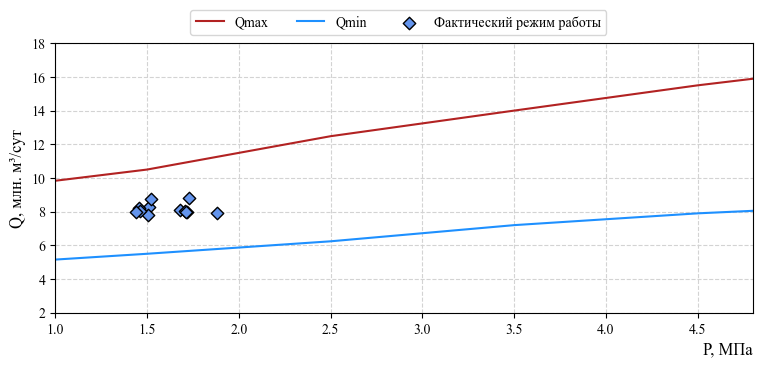

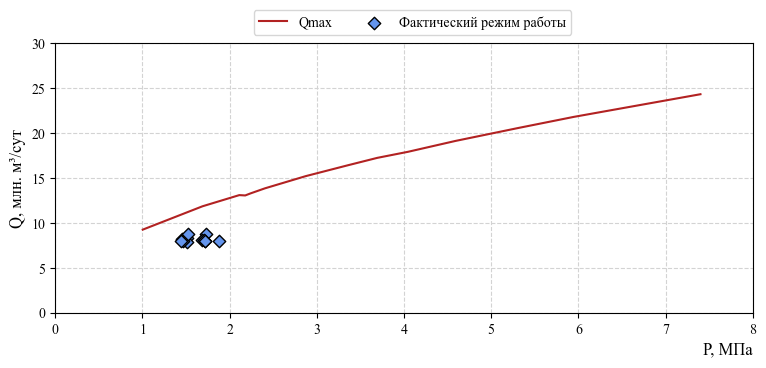

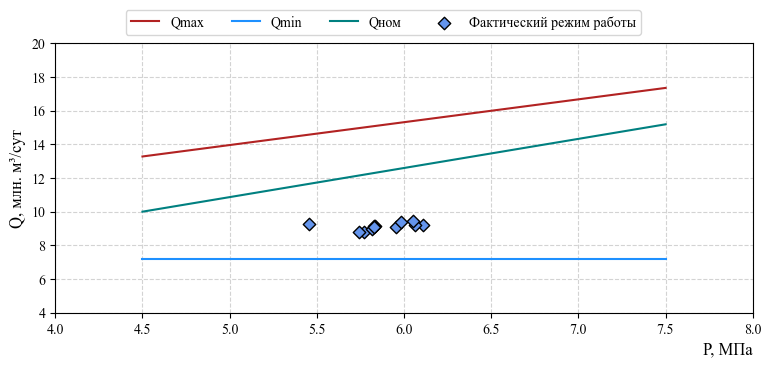

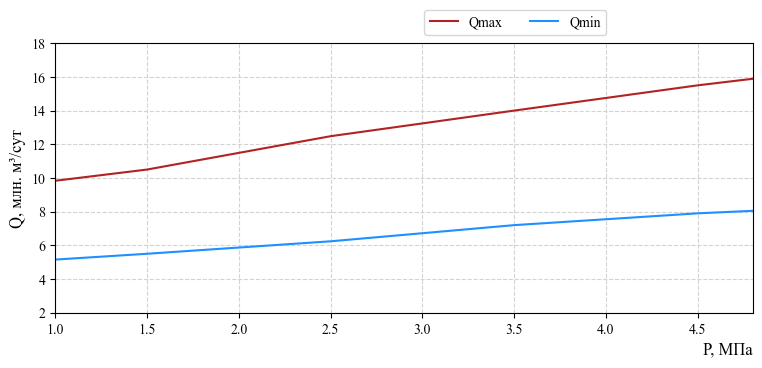

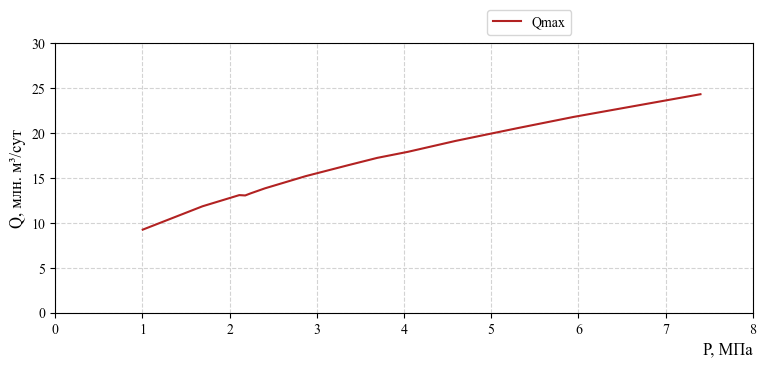

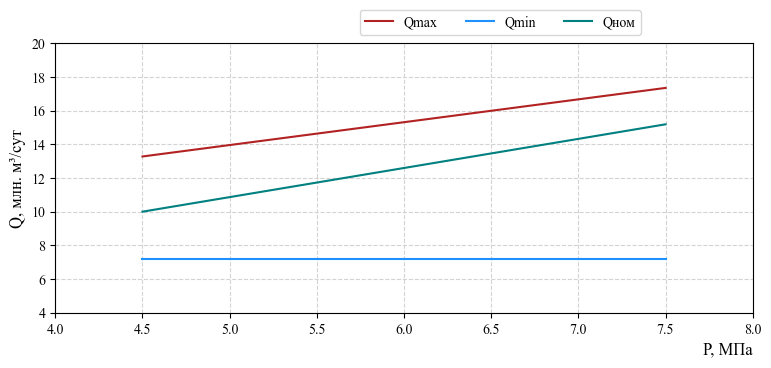

In [146]:
#сепаратор
URuss_separator = pd.DataFrame()
URuss_separator['P_max_sep'] = [0.5,1.5,2.5,3.5,4.5,5.5] 
URuss_separator['Qmax_sep'] = [9.17,10.5,12.48,14,15.5,16.8]
URuss_separator['P_min_sep'] = [0.5,1.5,2.5,3.5,4.5,5.5] 
URuss_separator['Qmin_sep'] = [4.81,5.5,6.24,7.2,7.9,8.4]
fig, ax = plt.subplots(figsize=(9, 3.5)) #создаем гарфик и его размеры
ax.plot(URuss_separator['P_max_sep'],URuss_separator['Qmax_sep'],color='firebrick',label='Qmax', zorder=1)
ax.plot(URuss_separator['P_min_sep'],URuss_separator['Qmin_sep'],color='dodgerblue',label='Qmin', zorder=1)
ax.scatter(res_month_sep.iloc[:,1], res_month_sep.iloc[:,10], c='cornflowerblue', edgecolors='black', s=40, marker='D',label='Фактический режим работы', zorder=2) #наносим точки
ax.set_xlabel('Р, МПа', fontsize=12,loc='right') #название оси x
ax.set_ylabel('Q, млн. м\u00b3/сут', fontsize= 12) #название оси у
ax.set_xlim(1,4.8)#пределы по у
ax.set_ylim(2,18)#пределы по у
ax.legend(fontsize = 10,bbox_to_anchor=(0.80, 1.15), ncol=3)
ax.set_axisbelow(True)
ax.grid(color='lightgray', linestyle='dashed', zorder=0) #сетка на графике
plt.savefig('сепаратор.jpg',bbox_inches="tight", dpi=200)
plt.show()
URuss_z_separator = pd.DataFrame()
URuss_z_separator['P_max_sep'] = [7.39987044534413,	6.85739271255061,5.94572874493927,5.3053036437247,4.58953441295547,4.04705668016194,3.69293927125506,3.35389068825911,2.87168825910931,2.40455465587045,2.2387975708502,2.17852226720648,2.11071255060729,1.68878542510121,1.00315384615385] 
URuss_z_separator['Qmax_sep'] = [24.3227482614742,23.3806063977747,21.7978080667594,20.5541808066759,19.1221251738526,17.9161835883171,17.2378414464534,16.4087566063978,15.2028150208623,13.8461307371349,13.280845618915,13.0547315716272,13.0924172461752,11.8487899860918,9.24847844228095]
fig, ax = plt.subplots(figsize=(9, 3.5)) #создаем гарфик и его размеры
ax.plot(URuss_z_separator['P_max_sep'],URuss_z_separator['Qmax_sep'],color='firebrick',label='Qmax', zorder=1)
ax.scatter(res_month_sep.iloc[:,1], res_month_sep.iloc[:,10], c='cornflowerblue', edgecolors='black', s=40, marker='D',label='Фактический режим работы', zorder=2) #наносим точки
ax.set_xlabel('Р, МПа', fontsize=12,loc='right') #название оси x
ax.set_ylabel('Q, млн. м\u00b3/сут', fontsize= 12) #название оси у
ax.set_xlim(0,8)#пределы по у
ax.set_ylim(0,30)#пределы по у
ax.legend(fontsize = 10,bbox_to_anchor=(0.75, 1.15), ncol=3)
ax.set_axisbelow(True)
ax.grid(color='lightgray', linestyle='dashed', zorder=0) #сетка на графике
plt.savefig('сепаратор 2.jpg',bbox_inches="tight", dpi=200)
plt.show()
#абсорбер
URuss_absorber = pd.DataFrame()
URuss_absorber['P_max_sep'] = [4.5,7.5] 
URuss_absorber['Qmax_sep'] = [13.276,17.3467]
URuss_absorber['P_min_sep'] = [4.5,7.5] 
URuss_absorber['Qmin_sep'] = [7.2,7.2]
URuss_absorber['P_nom_sep'] = [4.5,7.5] 
URuss_absorber['Qnom_sep'] = [9.999, 15.1862]
fig, ax = plt.subplots(figsize=(9, 3.5)) #создаем гарфик и его размеры
ax.plot(URuss_absorber['P_max_sep'],URuss_absorber['Qmax_sep'],color='firebrick',label='Qmax', zorder=1)
ax.plot(URuss_absorber['P_min_sep'],URuss_absorber['Qmin_sep'],color='dodgerblue',label='Qmin', zorder=1)
ax.plot(URuss_absorber['P_nom_sep'],URuss_absorber['Qnom_sep'],color='teal',label='Qном', zorder=1)
ax.scatter(res_month_abs.iloc[:,2], res_month_abs.iloc[:,5], c='cornflowerblue', edgecolors='black', s=40, marker='D',label='Фактический режим работы', zorder=2) #наносим точки
ax.set_xlabel('Р, МПа', fontsize=12,loc='right') #название оси x
ax.set_ylabel('Q, млн. м\u00b3/сут', fontsize= 12) #название оси у
ax.set_xlim(4,8)#пределы по у
ax.set_ylim(4,20)#пределы по у
ax.legend(fontsize = 10,bbox_to_anchor=(0.85, 1.15), ncol=4)
ax.set_axisbelow(True)
ax.grid(color='lightgray', linestyle='dashed', zorder=0) #сетка на графике
plt.savefig('абсорбер.jpg',bbox_inches="tight", dpi=200)
plt.show()

#сепаратор
URuss_separator = pd.DataFrame()
URuss_separator['P_max_sep'] = [0.5,1.5,2.5,3.5,4.5,5.5] 
URuss_separator['Qmax_sep'] = [9.17,10.5,12.48,14,15.5,16.8]
URuss_separator['P_min_sep'] = [0.5,1.5,2.5,3.5,4.5,5.5] 
URuss_separator['Qmin_sep'] = [4.81,5.5,6.24,7.2,7.9,8.4]
fig, ax = plt.subplots(figsize=(9, 3.5)) #создаем гарфик и его размеры
ax.plot(URuss_separator['P_max_sep'],URuss_separator['Qmax_sep'],color='firebrick',label='Qmax', zorder=1)
ax.plot(URuss_separator['P_min_sep'],URuss_separator['Qmin_sep'],color='dodgerblue',label='Qmin', zorder=1)
ax.set_xlabel('Р, МПа', fontsize=12,loc='right') #название оси x
ax.set_ylabel('Q, млн. м\u00b3/сут', fontsize= 12) #название оси у
ax.set_xlim(1,4.8)#пределы по у
ax.set_ylim(2,18)#пределы по у
ax.legend(fontsize = 10,bbox_to_anchor=(0.80, 1.15), ncol=3)
ax.set_axisbelow(True)
ax.grid(color='lightgray', linestyle='dashed', zorder=0) #сетка на графике
plt.savefig('сепаратор(ном).jpg',bbox_inches="tight", dpi=200)
plt.show()
URuss_z_separator = pd.DataFrame()
URuss_z_separator['P_max_sep'] = [7.39987044534413,	6.85739271255061,5.94572874493927,5.3053036437247,4.58953441295547,4.04705668016194,3.69293927125506,3.35389068825911,2.87168825910931,2.40455465587045,2.2387975708502,2.17852226720648,2.11071255060729,1.68878542510121,1.00315384615385] 
URuss_z_separator['Qmax_sep'] = [24.3227482614742,23.3806063977747,21.7978080667594,20.5541808066759,19.1221251738526,17.9161835883171,17.2378414464534,16.4087566063978,15.2028150208623,13.8461307371349,13.280845618915,13.0547315716272,13.0924172461752,11.8487899860918,9.24847844228095]
fig, ax = plt.subplots(figsize=(9, 3.5)) #создаем гарфик и его размеры
ax.plot(URuss_z_separator['P_max_sep'],URuss_z_separator['Qmax_sep'],color='firebrick',label='Qmax', zorder=1)
ax.set_xlabel('Р, МПа', fontsize=12,loc='right') #название оси x
ax.set_ylabel('Q, млн. м\u00b3/сут', fontsize= 12) #название оси у
ax.set_xlim(0,8)#пределы по у
ax.set_ylim(0,30)#пределы по у
ax.legend(fontsize = 10,bbox_to_anchor=(0.75, 1.15), ncol=3)
ax.set_axisbelow(True)
ax.grid(color='lightgray', linestyle='dashed', zorder=0) #сетка на графике
plt.savefig('сепаратор 2(ном).jpg',bbox_inches="tight", dpi=200)
plt.show()
#абсорбер
URuss_absorber = pd.DataFrame()
URuss_absorber['P_max_sep'] = [4.5,7.5] 
URuss_absorber['Qmax_sep'] = [13.276,17.3467]
URuss_absorber['P_min_sep'] = [4.5,7.5] 
URuss_absorber['Qmin_sep'] = [7.2,7.2]
URuss_absorber['P_nom_sep'] = [4.5,7.5] 
URuss_absorber['Qnom_sep'] = [9.999, 15.1862]
fig, ax = plt.subplots(figsize=(9, 3.5)) #создаем гарфик и его размеры
ax.plot(URuss_absorber['P_max_sep'],URuss_absorber['Qmax_sep'],color='firebrick',label='Qmax', zorder=1)
ax.plot(URuss_absorber['P_min_sep'],URuss_absorber['Qmin_sep'],color='dodgerblue',label='Qmin', zorder=1)
ax.plot(URuss_absorber['P_nom_sep'],URuss_absorber['Qnom_sep'],color='teal',label='Qном', zorder=1)
ax.set_xlabel('Р, МПа', fontsize=12,loc='right') #название оси x
ax.set_ylabel('Q, млн. м\u00b3/сут', fontsize= 12) #название оси у
ax.set_xlim(4,8)#пределы по у
ax.set_ylim(4,20)#пределы по у
ax.legend(fontsize = 10,bbox_to_anchor=(0.85, 1.15), ncol=4)
ax.set_axisbelow(True)
ax.grid(color='lightgray', linestyle='dashed', zorder=0) #сетка на графике
plt.savefig('абсорбер(ном).jpg',bbox_inches="tight", dpi=200)
plt.show()

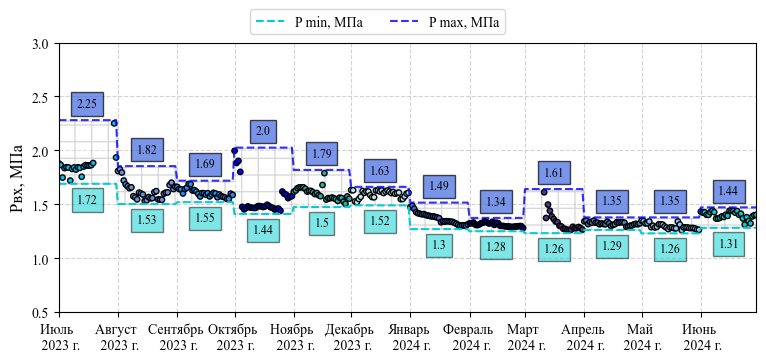

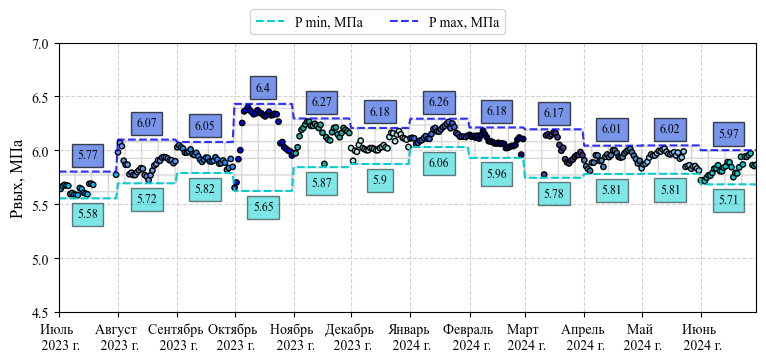

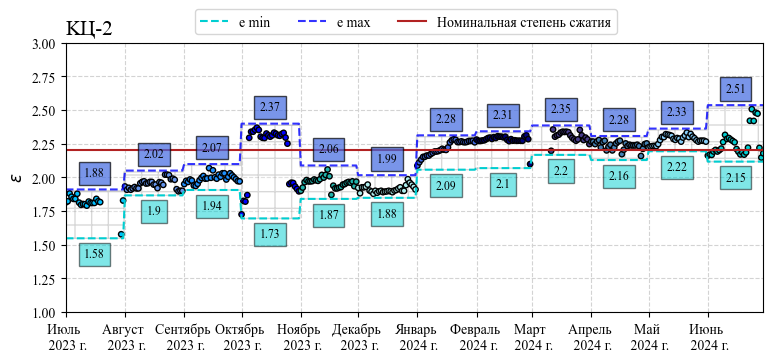

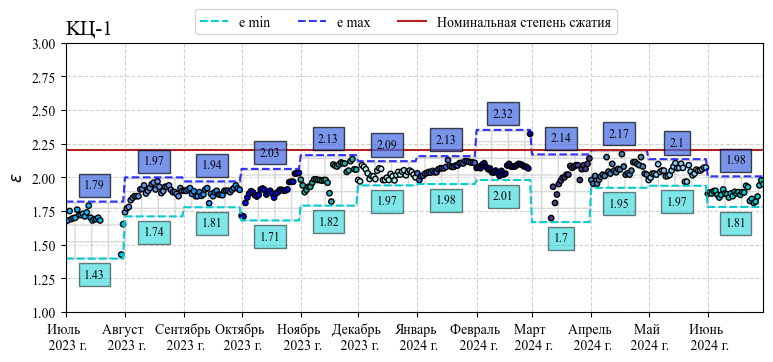

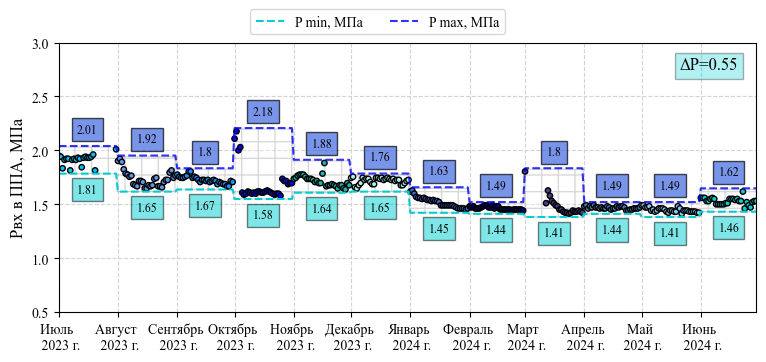

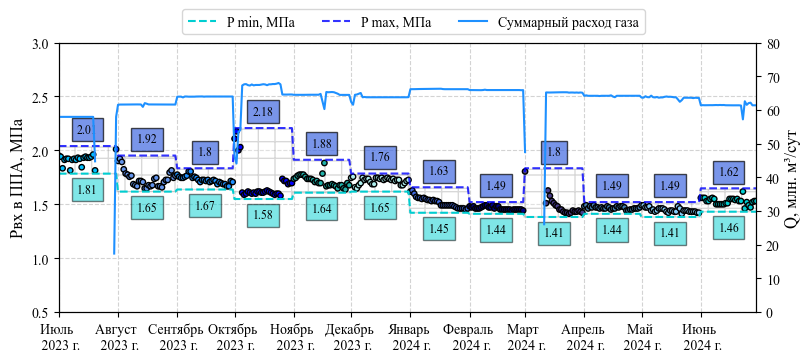

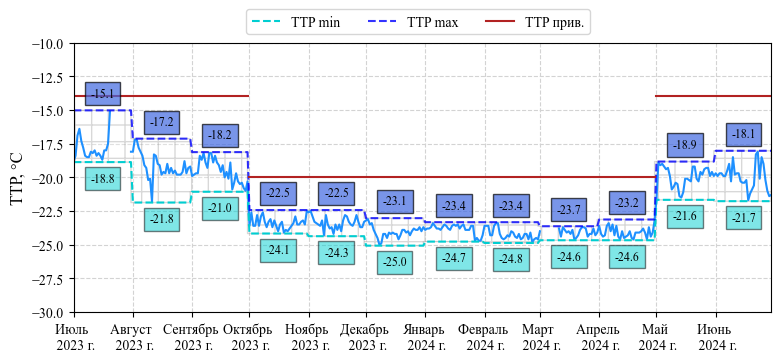

In [239]:
mpl.rc('font',family='Times New Roman') #везде TNR
locale.setlocale(locale.LC_ALL, 'ru_RU.UTF-8') #русский язык
formatter = DateFormatter('%B \n %Y г.') #формат даты
res_year['Дата'] = pd.to_datetime(res_year['Дата'], dayfirst=True)
date_min = res_year['Дата'].dt.date.min()
date_max = res_year['Дата'].dt.date.max()
def set_color(date):  #задаем цвета для каждого месяца свой
    color_dict = {
        1: 'royalblue',
        2: 'navy',
        3: 'darkslateblue',
        4: 'steelblue',
        5: 'lightskyblue',
        6: 'darkturquoise',
        7: 'deepskyblue',
        8: 'cornflowerblue',
        9: 'dodgerblue',
        10: 'blue',
        11: 'lightseagreen',
        12: 'paleturquoise'
    }
    month = date.month
    return color_dict[month]
res_year['color'] = res_year['Дата'].apply(set_color)
#Р_вх
res_year['month'] = res_year['Дата'].dt.month
res_year['P_min'] = res_year.groupby('month', as_index=False)['Р_вх'].transform(min) #ищем максимумы и минимумы по месяцам
res_year['P_max'] = res_year.groupby('month', as_index=False)['Р_вх'].transform(max)
df_mark = res_year.groupby('month').agg({'Дата': 'mean','P_min':'min', 'P_max':'max'}) #местоположение подписей на графике
fig_1, ax = plt.subplots(figsize=(9, 3.5)) #создаем гарфик и его размеры
plt.fill_between(res_year['Дата'], res_year['P_min']-0.03, res_year['P_max']+0.02, step="mid", alpha=0.3, hatch='+', color = 'white', edgecolor='grey') #заливка в выбранной области
plt.scatter(res_year['Дата'], res_year['Р_вх'], c=res_year['color'],edgecolors='black', s=15) #наносим точки
plt.plot(res_year['Дата'], res_year['P_min']-0.03, color='darkturquoise', linestyle='--', label='P min, МПа') #линии мин и макс
plt.plot(res_year['Дата'], res_year['P_max']+0.03, color='b', alpha=0.8, linestyle='--', label='P max, МПа') 
bbox_min = dict(facecolor='darkturquoise',alpha=0.5) #заливка подписей на графике
bbox_max = dict(facecolor='royalblue',alpha=0.7)
df_mark.apply(lambda d: ax.text(d['Дата'],d['P_min']-0.18, round(d['P_min'],2), bbox=bbox_min, va='center', ha = 'center', fontsize=8.5), axis=1) #подписи на графике:местоположение, значения, формат   
df_mark.apply(lambda d: ax.text(d['Дата'],d['P_max']+0.18, round(d['P_max'],2), bbox=bbox_max, va='center', ha = 'center', fontsize=8.5), axis=1)  
ax.xaxis.set_major_formatter(formatter) #формат даты
ax.set_xlim([date_min,date_max]) #пределы по х
ax.set_ylim(0.5,3)#пределы по у
ax.set_ylabel('Рвх, МПа', fontsize=12) #название оси у
ax.set_axisbelow(True)
ax.grid(color='lightgray', linestyle='dashed') #сетка на графике
plt.legend(fontsize = 10,bbox_to_anchor=(0.65, 1.15), ncol=2) #легенда
plt.savefig('P_входа.jpg',bbox_inches="tight", dpi=200)
plt.show()
#Р_вых
res_year['Р_вых'] = res_year['Р_вых'][res_year['Р_вых'] > 5]
res_year['P_min_vih'] = res_year.groupby('month', as_index=False)['Р_вых'].transform(min) #ищем максимумы и минимумы по месяцам
res_year['P_max_vih'] = res_year.groupby('month', as_index=False)['Р_вых'].transform(max)
df_mark = res_year.groupby('month').agg({'Дата': 'mean','P_min_vih':'min', 'P_max_vih':'max'}) #местоположение подписей на графике
fig_1, ax = plt.subplots(figsize=(9, 3.5)) #создаем гарфик и его размеры
plt.fill_between(res_year['Дата'], res_year['P_min_vih']-0.03, res_year['P_max_vih']+0.02, step="mid", alpha=0.3, hatch='+', color = 'white', edgecolor='grey') #заливка в выбранной области
plt.scatter(res_year['Дата'], res_year['Р_вых'], c=res_year['color'],edgecolors='black', s=15) #наносим точки
plt.plot(res_year['Дата'], res_year['P_min_vih']-0.03, color='darkturquoise', linestyle='--', label='P min, МПа') #линии мин и макс
plt.plot(res_year['Дата'], res_year['P_max_vih']+0.03, color='b', alpha=0.8, linestyle='--', label='P max, МПа') 
bbox_min = dict(facecolor='darkturquoise',alpha=0.5) #заливка подписей на графике
bbox_max = dict(facecolor='royalblue',alpha=0.7)
df_mark.apply(lambda d: ax.text(d['Дата'],d['P_min_vih']-0.18, round(d['P_min_vih'],2), bbox=bbox_min, va='center', ha = 'center', fontsize=8.5), axis=1) #подписи на графике:местоположение, значения, формат   
df_mark.apply(lambda d: ax.text(d['Дата'],d['P_max_vih']+0.18, round(d['P_max_vih'],2), bbox=bbox_max, va='center', ha = 'center', fontsize=8.5), axis=1)  
ax.xaxis.set_major_formatter(formatter) #формат даты
ax.set_xlim([date_min,date_max]) #пределы по х
ax.set_ylim(4.5,7)#пределы по у
ax.set_ylabel('Рвых, МПа', fontsize=12) #название оси у
ax.set_axisbelow(True)
ax.grid(color='lightgray', linestyle='dashed') #сетка на графике
plt.legend(fontsize = 10,bbox_to_anchor=(0.65, 1.15), ncol=2) #легенда
plt.savefig('P_выхода.jpg',bbox_inches="tight", dpi=200)
plt.show()
#степень сжатия 1
res_year['E_ном'] = 2.20
res_year['E_min_1ст'] = res_year.groupby('month', as_index=False)['е_1_ст'].transform(min) #ищем максимумы и минимумы по месяцам
res_year['E_max_1ст'] = res_year.groupby('month', as_index=False)['е_1_ст'].transform(max)
df_mark = res_year.groupby('month').agg({'Дата': 'mean','E_min_1ст':'min', 'E_max_1ст':'max'}) #местоположение подписей на графике
fig_1, ax = plt.subplots(figsize=(9, 3.5)) #создаем гарфик и его размеры
plt.fill_between(res_year['Дата'], res_year['E_min_1ст']-0.03, res_year['E_max_1ст']+0.02, step="mid", alpha=0.3, hatch='+', color = 'white', edgecolor='grey') #заливка в выбранной области
plt.scatter(res_year['Дата'], res_year['е_1_ст'], c=res_year['color'],edgecolors='black', s=15) #наносим точки
plt.plot(res_year['Дата'], res_year['E_min_1ст']-0.03, color='darkturquoise', linestyle='--', label='e min') #линии мин и макс
plt.plot(res_year['Дата'], res_year['E_max_1ст']+0.03, color='b', alpha=0.8, linestyle='--', label='e max') 
ax.plot(res_year['Дата'],res_year['E_ном'],color='firebrick',label='Номинальная степень сжатия', zorder=2)
bbox_min = dict(facecolor='darkturquoise',alpha=0.5) #заливка подписей на графике
bbox_max = dict(facecolor='royalblue',alpha=0.7)
df_mark.apply(lambda d: ax.text(d['Дата'],d['E_min_1ст']-0.15, round(d['E_min_1ст'],2), bbox=bbox_min, va='center', ha = 'center', fontsize=8.5), axis=1) #подписи на графике:местоположение, значения, формат   
df_mark.apply(lambda d: ax.text(d['Дата'],d['E_max_1ст']+0.15, round(d['E_max_1ст'],2), bbox=bbox_max, va='center', ha = 'center', fontsize=8.5), axis=1)  
ax.xaxis.set_major_formatter(formatter) #формат даты
ax.set_xlim([date_min,date_max]) #пределы по х
ax.set_ylim(1,3)#пределы по у
ax.set_ylabel('$\epsilon$', fontsize=12) #название оси у
ax.set_axisbelow(True)
ax.grid(color='lightgray', linestyle='dashed') #сетка на графике
plt.legend(fontsize = 10,bbox_to_anchor=(0.80, 1.15), ncol=3) #легенда
plt.title('KЦ-2', fontsize = 15,loc = 'left')
plt.savefig('Ст.Сж.1.jpg',bbox_inches="tight", dpi=200)
plt.show()
#степень сжатия 2
res_year['E_min_2ст'] = res_year.groupby('month', as_index=False)['е_2_ст'].transform(min) #ищем максимумы и минимумы по месяцам
res_year['E_max_2ст'] = res_year.groupby('month', as_index=False)['е_2_ст'].transform(max)
df_mark = res_year.groupby('month').agg({'Дата': 'mean','E_min_2ст':'min', 'E_max_2ст':'max'}) #местоположение подписей на графике
fig_1, ax = plt.subplots(figsize=(9, 3.5)) #создаем гарфик и его размеры
plt.fill_between(res_year['Дата'], res_year['E_min_2ст']-0.03, res_year['E_max_2ст']+0.02, step="mid", alpha=0.3, hatch='+', color = 'white', edgecolor='grey') #заливка в выбранной области
plt.scatter(res_year['Дата'], res_year['е_2_ст'], c=res_year['color'],edgecolors='black', s=15) #наносим точки
plt.plot(res_year['Дата'], res_year['E_min_2ст']-0.03, color='darkturquoise', linestyle='--', label='e min') #линии мин и макс
plt.plot(res_year['Дата'], res_year['E_max_2ст']+0.03, color='b', alpha=0.8, linestyle='--', label='e max') 
ax.plot(res_year['Дата'],res_year['E_ном'],color='firebrick',label='Номинальная степень сжатия', zorder=2)
bbox_min = dict(facecolor='darkturquoise',alpha=0.5) #заливка подписей на графике
bbox_max = dict(facecolor='royalblue',alpha=0.7)
df_mark.apply(lambda d: ax.text(d['Дата'],d['E_min_2ст']-0.15, round(d['E_min_2ст'],2), bbox=bbox_min, va='center', ha = 'center', fontsize=8.5), axis=1) #подписи на графике:местоположение, значения, формат   
df_mark.apply(lambda d: ax.text(d['Дата'],d['E_max_2ст']+0.15, round(d['E_max_2ст'],2), bbox=bbox_max, va='center', ha = 'center', fontsize=8.5), axis=1)  
ax.xaxis.set_major_formatter(formatter) #формат даты
ax.set_xlim([date_min,date_max]) #пределы по х
ax.set_ylim(1,3)#пределы по у
ax.set_ylabel('$\epsilon$', fontsize=12) #название оси у
ax.set_axisbelow(True)
ax.grid(color='lightgray', linestyle='dashed') #сетка на графике
plt.legend(fontsize = 10,bbox_to_anchor=(0.80, 1.15), ncol=3) #легенда
plt.title('KЦ-1', fontsize = 15,loc = 'left')
plt.savefig('Ст.Сж.2.jpg',bbox_inches="tight", dpi=200)
plt.show()
#Pвх в ППА
res_year['Р_ППА'] = res_year['Р_ППА'][res_year['Р_ППА'] < 2.5]
res_year['P_min_ppa'] = res_year.groupby('month', as_index=False)['Р_ППА'].transform(min) #ищем максимумы и минимумы по месяцам
res_year['P_max_ppa'] = res_year.groupby('month', as_index=False)['Р_ППА'].transform(max)
df_mark = res_year.groupby('month').agg({'Дата': 'mean','P_min_ppa':'min', 'P_max_ppa':'max'}) #местоположение подписей на графике
fig_1, ax = plt.subplots(figsize=(9, 3.5)) #создаем гарфик и его размеры
plt.fill_between(res_year['Дата'], res_year['P_min_ppa']-0.03, res_year['P_max_ppa']+0.02, step="mid", alpha=0.3, hatch='+', color = 'white', edgecolor='grey') #заливка в выбранной области
plt.scatter(res_year['Дата'], res_year['Р_ППА'], c=res_year['color'],edgecolors='black', s=15) #наносим точки
ax.plot(res_year['Дата'], res_year['P_min_ppa']-0.03, color='darkturquoise', linestyle='--', label='P min, МПа') #линии мин и макс
ax.plot(res_year['Дата'], res_year['P_max_ppa']+0.03, color='b', alpha=0.8, linestyle='--', label='P max, МПа') 
bbox_min = dict(facecolor='darkturquoise',alpha=0.5) #заливка подписей на графике
bbox_max = dict(facecolor='royalblue',alpha=0.7)
df_mark.apply(lambda d: ax.text(d['Дата'],d['P_min_ppa']-0.18, round(d['P_min_ppa'],2), bbox=bbox_min, va='center', ha = 'center', fontsize=8.5), axis=1) #подписи на графике:местоположение, значения, формат   
df_mark.apply(lambda d: ax.text(d['Дата'],d['P_max_ppa']+0.18, round(d['P_max_ppa'],2), bbox=bbox_max, va='center', ha = 'center', fontsize=8.5), axis=1) 
dp = (res_year['P_max_ppa'][0] - res_year['P_min_ppa'][364]).__round__(2) 
text = 'ΔP='
plt.text(res_year.Дата.values[325],2.75, f'{text}{dp}', fontsize=12, bbox={'boxstyle':'square', 'facecolor': 'darkturquoise', 'alpha':0.3})  
ax.xaxis.set_major_formatter(formatter) #формат даты
ax.set_xlim([date_min,date_max]) #пределы по х
ax.set_ylim(0.5,3)#пределы по у
ax.set_ylabel('Рвх в ППА, МПа', fontsize=12) #название оси у
ax.set_axisbelow(True)
ax.grid(color='lightgray', linestyle='dashed') #сетка на графике
plt.legend(fontsize = 10,bbox_to_anchor=(0.65, 1.15), ncol=2) #легенда
plt.savefig('P_вх в ппа.jpg',bbox_inches="tight", dpi=200)
plt.show()
#Pвх в ППА с расходом
res_year['Р_ППА'] = res_year['Р_ППА'][res_year['Р_ППА'] < 2.5]
res_year['P_min_ppa'] = res_year.groupby('month', as_index=False)['Р_ППА'].transform(min) #ищем максимумы и минимумы по месяцам
res_year['P_max_ppa'] = res_year.groupby('month', as_index=False)['Р_ППА'].transform(max)
df_mark = res_year.groupby('month').agg({'Дата': 'mean','P_min_ppa':'min', 'P_max_ppa':'max'}) #местоположение подписей на графике
fig_1, ax = plt.subplots(figsize=(9, 3.5)) #создаем гарфик и его размеры
plt.fill_between(res_year['Дата'], res_year['P_min_ppa']-0.03, res_year['P_max_ppa']+0.02, step="mid", alpha=0.3, hatch='+', color = 'white', edgecolor='grey') #заливка в выбранной области
plt.scatter(res_year['Дата'], res_year['Р_ППА'], c=res_year['color'],edgecolors='black', s=15) #наносим точки
x1 = ax.plot(res_year['Дата'], res_year['P_min_ppa']-0.03, color='darkturquoise', linestyle='--', label='P min, МПа') #линии мин и макс
x2 = ax.plot(res_year['Дата'], res_year['P_max_ppa']+0.03, color='b', alpha=0.8, linestyle='--', label='P max, МПа') 
ax2 = ax.twinx() #делаем дополнительную ось
x3=ax2.plot(res_year['Дата'], res_year['Q'], c='dodgerblue',label='Суммарный расход газа')
ax2.set_ylim(0,80)#пределы по у_2
ax2.set_ylabel('Q, млн. м\u00b3/сут', fontsize= 12)
bbox_min = dict(facecolor='darkturquoise',alpha=0.5) #заливка подписей на графике
bbox_max = dict(facecolor='royalblue',alpha=0.7)
df_mark.apply(lambda d: ax.text(d['Дата'],d['P_min_ppa']-0.18, round(d['P_min_ppa'],2), bbox=bbox_min, va='center', ha = 'center', fontsize=8.5), axis=1) #подписи на графике:местоположение, значения, формат   
df_mark.apply(lambda d: ax.text(d['Дата'],d['P_max_ppa']+0.18, round(d['P_max_ppa'],2), bbox=bbox_max, va='center', ha = 'center', fontsize=8.5), axis=1) 
ax.xaxis.set_major_formatter(formatter) #формат даты
ax.set_xlim([date_min,date_max]) #пределы по х
ax.set_ylim(0.5,3)#пределы по у
ax.set_ylabel('Рвх в ППА, МПа', fontsize=12) #название оси у
ax.set_axisbelow(True)
ax.grid(color='lightgray', linestyle='dashed') #сетка на графике
labels = [x1[0],x2[0],x3[0]] 
leg = [l.get_label() for l in labels]
ax.legend(labels, leg,bbox_to_anchor=(0.85, 1.15), ncol=3)
plt.savefig('P_вх в ппа с расходом.jpg',bbox_inches="tight", dpi=200)
plt.show()
#ТТР 
res_year['TTP'] = res_year['TTP'][res_year['TTP'] < -14]
res_year['TTP_kr_s'] = res_year['Дата'].apply(lambda d: -14 if 5<=d.month<=9 else None)
res_year['TTP_kr_w'] = res_year['Дата'].apply(lambda d: -20 if (1<=d.month<=4) | (d.month>=10) else None)
res_year['TTP_min'] = res_year.groupby('month', as_index=False)['TTP'].transform(min)
res_year['TTP_max'] = res_year.groupby('month', as_index=False)['TTP'].transform(max)
df_mark = res_year.groupby('month').agg({'Дата': 'mean','TTP_min':'min', 'TTP_max':'max'})
fig, ax = plt.subplots(figsize=(9, 3.5))
plt.fill_between(res_year['Дата'], res_year['TTP_min']-0.07, res_year['TTP_max']+0.07,step="pre", alpha=0.3,hatch='+',color = 'white',edgecolor='grey')
plt.plot(res_year['Дата'], res_year['TTP'], c='dodgerblue')
plt.plot(res_year['Дата'], res_year['TTP_min']-0.07, color='darkturquoise', linestyle='--', label='ТТP min')
plt.plot(res_year['Дата'], res_year['TTP_max']+0.07, color='b', alpha=0.8, linestyle='--', label='ТТP max')
plt.plot(res_year['Дата'], res_year['TTP_kr_s'], color='firebrick', label='ТТP прив.')
plt.plot(res_year['Дата'], res_year['TTP_kr_w'], color='firebrick')
bbox_min = dict(facecolor='darkturquoise',alpha=0.5) 
bbox_max = dict(facecolor='royalblue',alpha=0.7) 
df_mark.apply(lambda d: ax.text(d['Дата'],d['TTP_min']-1.3, round(d['TTP_min'],2),bbox=bbox_min,va='center',ha = 'center', fontsize=8.5),axis=1)     
df_mark.apply(lambda d: ax.text(d['Дата'],d['TTP_max']+1.3, round(d['TTP_max'],2),bbox=bbox_max,va='center',ha = 'center', fontsize=8.5),axis=1) 
ax.xaxis.set_major_formatter(formatter)
ax.set_xlim([date_min,date_max]) #пределы по х
ax.set_ylim(-30,-10)
ax.set_ylabel('ТТР, \u00b0С', fontsize=12)
ax.set_axisbelow(True)
ax.grid(color='lightgray', linestyle='dashed')
plt.legend(fontsize = 10,bbox_to_anchor=(0.75, 1.15), ncol=3)
plt.savefig('ТТР.jpg',bbox_inches="tight", dpi=200)
plt.show()


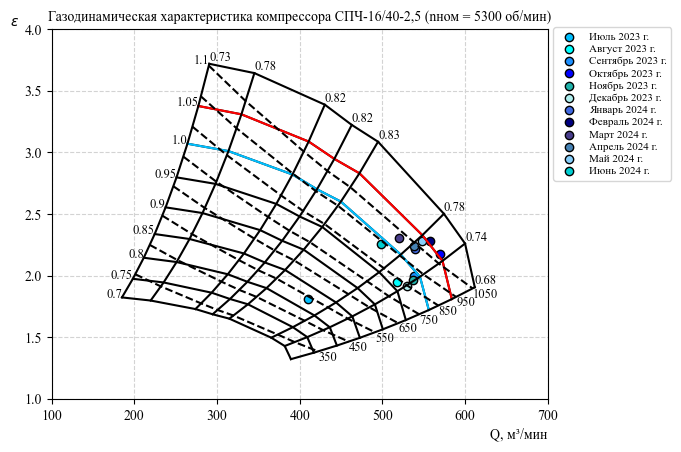

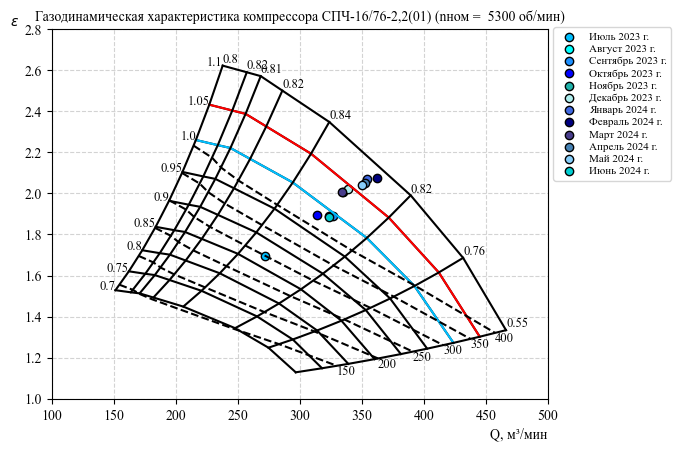

In [240]:
#Работа с ГДХ
mpl.rc('font',family='Times New Roman') #везде TNR
locale.setlocale(locale.LC_ALL, 'ru_RU.UTF-8') #русский язык
formatter = DateFormatter('%B \n %Y г.') #формат даты
data = pd.read_excel('Факт-2023г\Факт 2023.xlsx', sheet_name='Таблицы для 2 ступ.сж.')  
res_month['Дата'] = pd.to_datetime(res_month['Дата'], dayfirst=True)
#СПЧ-16/40-2,5
#n/nном
end_row = data[data.iloc[:, 0].isna()].index.min()
data1 = data.iloc[:end_row, :10]
data1 = data1.iloc[2:]
data1.columns = ['Параметр', 'кпд', '1', '2', '3', '4', '5', '6', '7','8']
data1.iloc[:, 1] = data1.iloc[:, 1].fillna(method='ffill')
data1 = data1[data1['Параметр'].isin(['Q, м3/мин', 'e'])]
#nпол
data2 = data.iloc[57:75, :11]
data2.columns = ['Параметр', 'кпд', '1', '2', '3', '4', '5', '6', '7', '8','9']
data2.iloc[:, 1] = data2.iloc[:, 1].fillna(method='ffill')
data2 = data2[data2['Параметр'].isin(['Q, м3/мин', 'e'])]
#N/pн
data3 = data.iloc[80:96, :10]
data3.columns = ['Параметр', 'кпд', '1', '2', '3', '4', '5', '6', '7', '8']
data3.iloc[:, 1] = data3.iloc[:, 1].fillna(method='ffill')
data3 = data3[data3['Параметр'].isin(['Q, м3/мин', 'e'])]
data3
def my_plot_1(data1,data2,data3):
    fig, ax = plt.subplots()
    for kpd in data1['кпд'].unique():
        sup_data = data1[data1['кпд']==kpd]
        ax.plot(sup_data.iloc[0, 2:], sup_data.iloc[1, 2:],color = 'black')
        if kpd == 1: 
            ax.plot(sup_data.iloc[0, 2:], sup_data.iloc[1, 2:],color = 'deepskyblue')
        if kpd == 1.05: 
            ax.plot(sup_data.iloc[0, 2:], sup_data.iloc[1, 2:],color = 'red')    
        ax.text(sup_data.iloc[0, 2], sup_data.iloc[1, 2], round(kpd, 2),ha = 'right',va = 'baseline', fontsize=9)
    for kpd in data2['кпд'].unique():
        sup_data = data2[data2['кпд']==kpd]
        ax.plot(sup_data.iloc[0, 2:], sup_data.iloc[1, 2:], color = 'black')
        ax.text(sup_data.iloc[0, 2:][8], sup_data.iloc[1, 2:][8], round(kpd, 2),ha = 'left',va = 'bottom', fontsize=9)
    for kpd in data3['кпд'].unique():
        sup_data = data3[data3['кпд']==kpd]
        ax.plot(sup_data.iloc[0, 2:], sup_data.iloc[1, 2:], color = 'black', linestyle='--')
        ax.text(sup_data.iloc[0, 2:][7], sup_data.iloc[1, 2:][7], round(kpd, 2),ha = 'left',va = 'top', fontsize=9)
    plt.title("Газодинамическая характеристика компрессора СПЧ-16/40-2,5 (nном = 5300 об/мин)", fontsize=10)
    ax.set_xlabel('Q, м\u00b3/мин', fontsize=10,loc='right')
    ax.set_ylabel(r'$\epsilon$', fontsize=10, rotation=0,loc='top')
    ax.set_xlim(100,700)
    ax.set_ylim(1,4)
    ax.set_axisbelow(True)
    ax.grid(color='lightgray', linestyle='dashed')
    return fig, ax
#СПЧ-16/76-2,2(01)
#n/nном
end_row = data[data.iloc[:, 0].isna()].index.min()
data4 = data.iloc[:end_row, 16:26]
data4 = data4.iloc[2:]
data4.columns = ['Параметр', 'кпд', '1', '2', '3', '4', '5', '6', '7', '8']
data4.iloc[:, 1] = data4.iloc[:, 1].fillna(method='ffill')
data4 = data4[data4['Параметр'].isin(['Q, м3/мин', 'e'])]
#nпол
data5 = data.iloc[57:75, 16:27]
data5.columns = ['Параметр', 'кпд', '1', '2', '3', '4', '5', '6', '7', '8','9']
data5.iloc[:, 1] = data5.iloc[:, 1].fillna(method='ffill')
data5 = data5[data5['Параметр'].isin(['Q, м3/мин', 'e'])]
# #N/pн
data6 = data.iloc[80:92, 16:26]
data6.columns = ['Параметр', 'кпд', '1', '2', '3', '4', '5', '6', '7', '8']
data6.iloc[:, 1] = data6.iloc[:, 1].fillna(method='ffill')
data6 = data6[data6['Параметр'].isin(['Q, м3/мин', 'e'])]
def my_plot_2(data4,data5,data6):
    fig, ax = plt.subplots()
    for kpd in data4['кпд'].unique():
        sup_data = data4[data4['кпд']==kpd]
        ax.plot(sup_data.iloc[0, 2:], sup_data.iloc[1, 2:],color = 'black')
        if kpd == 1: 
            ax.plot(sup_data.iloc[0, 2:], sup_data.iloc[1, 2:],color = 'deepskyblue')
        if kpd == 1.05: 
            ax.plot(sup_data.iloc[0, 2:], sup_data.iloc[1, 2:],color = 'red')    
        ax.text(sup_data.iloc[0, 2], sup_data.iloc[1, 2], round(kpd, 2),ha = 'right',va = 'baseline', fontsize=9)
    for kpd in data5['кпд'].unique():
        sup_data = data5[data5['кпд']==kpd]
        ax.plot(sup_data.iloc[0, 2:], sup_data.iloc[1, 2:], color = 'black')
        ax.text(sup_data.iloc[0, 2:][8], sup_data.iloc[1, 2:][8], round(kpd, 2),ha = 'left',va = 'bottom', fontsize=9)
    for kpd in data6['кпд'].unique():
        sup_data = data6[data6['кпд']==kpd]
        ax.plot(sup_data.iloc[0, 2:], sup_data.iloc[1, 2:], color = 'black', linestyle='--')
        ax.text(sup_data.iloc[0, 2:][7], sup_data.iloc[1, 2:][7], round(kpd, 2),ha = 'left',va = 'top', fontsize=9)
    plt.title("Газодинамическая характеристика компрессора СПЧ-16/76-2,2(01) (nном =  5300 об/мин)", fontsize=10)
    ax.set_xlabel('Q, м\u00b3/мин', fontsize=10,loc='right')
    ax.set_ylabel(r'$\epsilon$', fontsize=10, rotation=0,loc='top')
    ax.set_xlim(100,500)
    ax.set_ylim(1,2.8)
    ax.set_axisbelow(True)
    ax.grid(color='lightgray', linestyle='dashed')
    return fig, ax
#Наносим рабочие точки на ГДХ
locale.setlocale(locale.LC_ALL, 'ru_RU.UTF-8') #русский язык
def set_color_month(date):  #задаем цвета для каждого месяца свой
    color_dict = {
        1: 'royalblue',
        2: 'navy',
        3: 'darkslateblue',
        4: 'steelblue',
        5: 'lightskyblue',
        6: 'darkturquoise',
        7: 'deepskyblue',
        8: 'aqua',
        9: 'dodgerblue',
        10: 'blue',
        11: 'lightseagreen',
        12: 'paleturquoise'
    }
    month = date.month
    return color_dict[month]
res_month['color'] = res_month['Дата'].apply(set_color_month)
#I ступень
E_1 = res_month.iloc[:,6]
Ppr_1st = res_month.iloc[:,4]/4.636
Tpr_1st = (res_month.iloc[:,5]+273.15)/193.15
Zpr_1st = 1-0.427*Ppr_1st*Tpr_1st**(-3.688)
po_vh_1st = res_month.iloc[0:,4]*10**6/(Zpr_1st*514*(res_month.iloc[0:,5]+273.15))
M_1st = (res_month.iloc[:,1]*10**6*0.682)/(3600*24)
Q_1st = (M_1st/po_vh_1st)*60/res_month.iloc[0:,2]
fig, ax = my_plot_1(data1,data2,data3)
for Q_1st, E_1, c, date in zip(Q_1st, E_1, res_month['color'], res_month['Дата']):
    plt.scatter(Q_1st, E_1, c=c, label=date.strftime('%B %Y г.'), edgecolors='black')
plt.legend(labelspacing=0.2,prop={'size':8},loc='upper right',bbox_to_anchor=(1.26, 1.02))
plt.savefig('ГДХ_1_ст.jpg',bbox_inches="tight", dpi=200)
#II ступень
E_2 = res_month.iloc[:,15]
Ppr_2st = res_month.iloc[:,13]/4.636
Tpr_2st = (res_month.iloc[:,14]+273.15)/193.15
Zpr_2st = 1-0.427*Ppr_2st*Tpr_2st**(-3.688)
po_vh_2st = res_month.iloc[0:,13]*10**6/(Zpr_2st*486.5*(res_month.iloc[0:,14]+273.15))
M_2st = (res_month.iloc[:,1]*10**6*0.682)/(3600*24)
Q_2st = (M_2st/po_vh_2st)*60/res_month.iloc[0:,11]
fig, ax = my_plot_2(data4,data5,data6)
for Q_2st, E_2, c, date in zip(Q_2st, E_2, res_month['color'], res_month['Дата']):
    plt.scatter(Q_2st, E_2, c=c, label=date.strftime('%B %Y г.'), edgecolors='black')
plt.legend(labelspacing=0.2,prop={'size':8},loc='upper right',bbox_to_anchor=(1.26, 1.02))
plt.savefig('ГДХ_2_ст.jpg',bbox_inches="tight", dpi=200)